In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import PVBM

In [4]:
import torch
torch.__version__

'2.7.1+cu126'

In [14]:
DATA_PATH = '/oriondata/AIMLab/renee.zac/Datasets/mbrset/mbrset-a-mobile-brazilian-retinal-dataset-1.0/'

In [49]:
IMAGES_PATH = os.path.join(DATA_PATH,'images/')

In [16]:
LABELS_CSV_PATH = os.path.join(DATA_PATH,'labels_mbrset.csv')

### Sex differentiation from biomarkers

In [ ]:
# vascular biomarkers
VBM_CSV_PATH = './mbrset_vbm_df.csv'

In [ ]:
# https://www.physionet.org/content/mbrset/1.0/
# sex: 0 for female and 1 for male
labels_df = pd.read_csv(LABELS_CSV_PATH)
labels_df.head()

,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,acute_myocardial_infarction,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no


In [25]:
len(labels_df.patient.unique())

1291

## Train val split .8/.2 on patients*

In [ ]:
from sklearn.model_selection import train_test_split

unique_patients = labels_df['patient'].unique()
train_patients, val_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

print(f"Train patients: {len(train_patients)}, Validation patients: {len(val_patients)}")

Train patients: 1032, Validation patients: 259


In [31]:
labels_df['Split'] = np.where(labels_df['patient'].isin(train_patients), 'train', 
                              np.where(labels_df['patient'].isin(val_patients), 'val', None))

### What is the image train/val split?

In [34]:
labels_df.Split.value_counts()

Split
train    4128
val      1036
Name: count, dtype: int64

## What is the sex-differentiation split?

In [35]:
labels_df.sex.value_counts()

sex
0    3360
1    1804
Name: count, dtype: int64

In [23]:
labels_df.columns

Index(['patient', 'age', 'sex', 'dm_time', 'insulin', 'insulin_time',
       'oraltreatment_dm', 'systemic_hypertension', 'insurance',
       'educational_level', 'alcohol_consumption', 'smoking', 'obesity',
       'vascular_disease', 'acute_myocardial_infarction', 'nephropathy',
       'neuropathy', 'diabetic_foot', 'file', 'laterality', 'final_artifacts',
       'final_quality', 'final_icdr', 'final_edema'],
      dtype='object')

In [24]:
labels_df.file

0         1.1.jpg
1         1.2.jpg
2         1.3.jpg
3         1.4.jpg
4        10.1.jpg
          ...    
5159    998.4.jpg
5160    999.1.jpg
5161    999.2.jpg
5162    999.3.jpg
5163    999.4.jpg
Name: file, Length: 5164, dtype: object

In [ ]:
labels = {}

In [ ]:
labels = labels_df['sex'].values

In [ ]:
vbm_df = pd.read_csv(VBM_CSV_PATH)
vbm_df.head()

,Artery_Area,Artery_Tortuosity_Index,Artery_Median_Tortuosity,Artery_Overall_Length,Artery_Median_Branching_Angles,Artery_N_Start_Points,Artery_N_End_Points,Artery_N_Intersection_Points,Vein_Area,Vein_Tortuosity_Index,Vein_Median_Tortuosity,Vein_Overall_Length,Vein_Median_Branching_Angles,Vein_N_Start_Points,Vein_N_End_Points,Vein_N_Intersection_Points,Index
0,20578.0,1.101783,1.075637,1555.893578,70.575740,4,5.0,1.0,49007.0,1.092587,1.084222,4196.864499,77.275644,4,13.0,12.0,47.4
1,49634.0,1.103772,1.087451,5520.839246,91.702621,9,17.0,9.0,57754.0,1.093053,1.081833,6274.276980,68.813001,11,25.0,14.0,378.3
2,39278.0,1.077895,1.074380,5061.986433,69.167245,9,14.0,5.0,47080.0,1.093832,1.079156,5861.105407,66.551865,8,19.0,13.0,207.1
3,34729.0,1.091477,1.084032,5386.770270,92.364036,7,13.0,5.0,38741.0,1.099560,1.081481,5342.461613,79.777831,8,16.0,11.0,1075.2
4,25567.0,1.064010,1.069275,2744.438959,62.311646,6,9.0,4.0,23127.0,1.079073,1.081001,2076.973880,74.009028,4,5.0,1.0,1023.3


In [10]:
np.unique(vbm_df['Index']).shape[0] == len(vbm_df)

True

In [11]:
vbm_df = vbm_df.set_index('Index')

Use linear regression to predict sex (labels_df sex column) from data (vbm_df) where data are split by labels_df Split column and labels_df joins to vbm_df on the 

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer

# Prepare join key for labels_df (remove file extension)
labels_df['vbm_index'] = labels_df['file'].str.replace('.jpg', '', regex=False)

# Ensure vbm_df index is string for join
vbm_df.index = vbm_df.index.astype(str)
# Join labels_df to vbm_df
merged = labels_df.join(vbm_df, on='vbm_index')

# Prepare features and targets for train/val splits
X_train = merged[merged['Split'] == 'train'][vbm_df.columns]
y_train = merged[merged['Split'] == 'train']['sex']
X_val = merged[merged['Split'] == 'val'][vbm_df.columns]
y_val = merged[merged['Split'] == 'val']['sex']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train_imputed, y_train)

# Predict on validation set
y_val_pred = lr.predict(X_val_imputed)
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_val_pred_binary)
auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation Accuracy: {acc:.3f}")
print(f"Validation ROC AUC: {auc:.3f}")

Validation Accuracy: 0.676
Validation ROC AUC: 0.600


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# Linear Regression (thresholded)
lr_precision = precision_score(y_val, y_val_pred_binary)
lr_recall = recall_score(y_val, y_val_pred_binary)
lr_f1 = f1_score(y_val, y_val_pred_binary)
lr_mcc = matthews_corrcoef(y_val, y_val_pred_binary)

print("Linear Regression (thresholded at 0.5):")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall: {lr_recall:.3f}")
print(f"F1 Score: {lr_f1:.3f}")
print(f"Matthews Corrcoef: {lr_mcc:.3f}")



Linear Regression (thresholded at 0.5):
Precision: 0.500
Recall: 0.012
F1 Score: 0.023
Matthews Corrcoef: 0.033


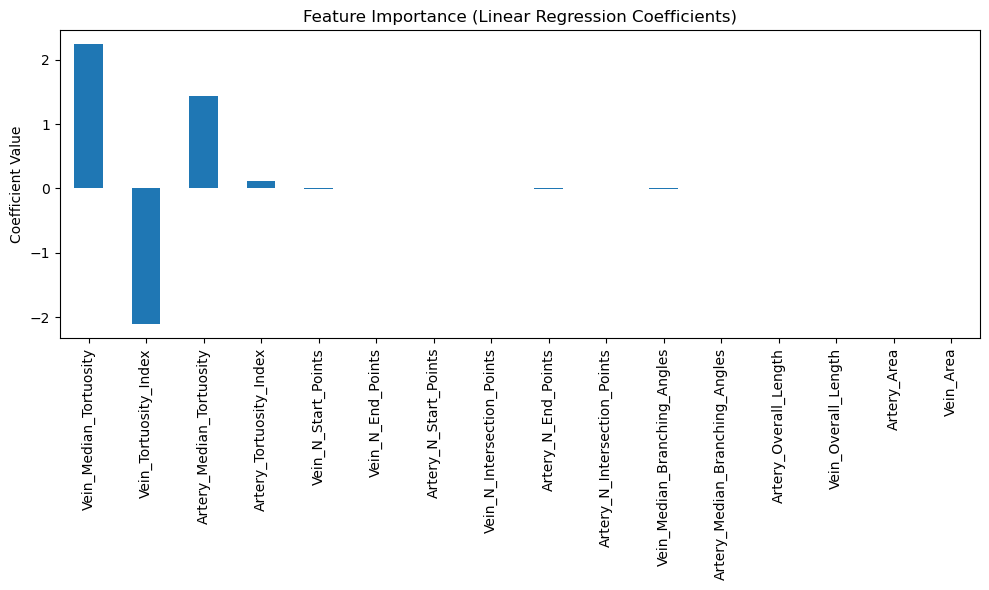

In [39]:
# Get feature importances (coefficients) from the linear regression model
feature_importance = pd.Series(lr.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

Random Forest Validation Accuracy: 0.638
Random Forest Validation ROC AUC: 0.509


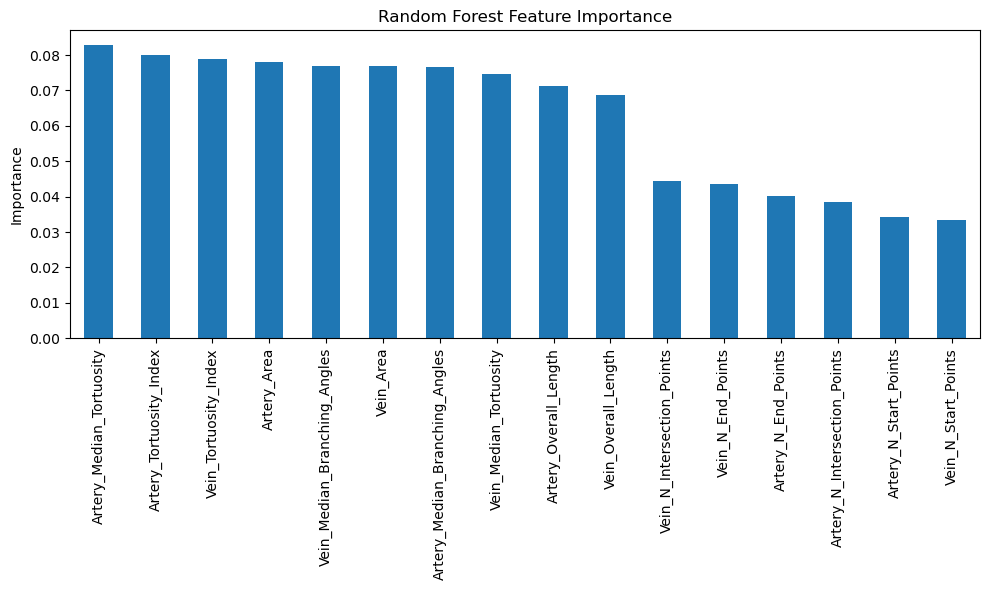

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on imputed data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Predict on validation set
y_val_rf_pred = rf.predict_proba(X_val_imputed)[:, 1]
y_val_rf_pred_binary = (y_val_rf_pred >= 0.5).astype(int)

# Evaluate
rf_acc = accuracy_score(y_val, y_val_rf_pred_binary)
rf_auc = roc_auc_score(y_val, y_val_rf_pred)

print(f"Random Forest Validation Accuracy: {rf_acc:.3f}")
print(f"Random Forest Validation ROC AUC: {rf_auc:.3f}")

# Feature importance
rf_feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_feature_importance.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [45]:
# Random Forest
rf_precision = precision_score(y_val, y_val_rf_pred_binary)
rf_recall = recall_score(y_val, y_val_rf_pred_binary)
rf_f1 = f1_score(y_val, y_val_rf_pred_binary)
rf_mcc = matthews_corrcoef(y_val, y_val_rf_pred_binary)

print("\nRandom Forest:")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print(f"Matthews Corrcoef: {rf_mcc:.3f}")


Random Forest:
Precision: 0.307
Recall: 0.092
F1 Score: 0.142
Matthews Corrcoef: -0.012


Linear Regression (thresholded at 0.5):
              precision    recall  f1-score   support

  Female (0)       0.68      0.99      0.81       700
    Male (1)       0.50      0.01      0.02       336

    accuracy                           0.68      1036
   macro avg       0.59      0.50      0.41      1036
weighted avg       0.62      0.68      0.55      1036



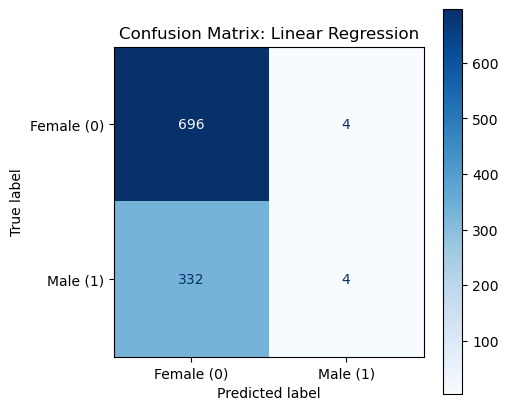

Random Forest:
              precision    recall  f1-score   support

  Female (0)       0.67      0.90      0.77       700
    Male (1)       0.31      0.09      0.14       336

    accuracy                           0.64      1036
   macro avg       0.49      0.50      0.46      1036
weighted avg       0.55      0.64      0.57      1036



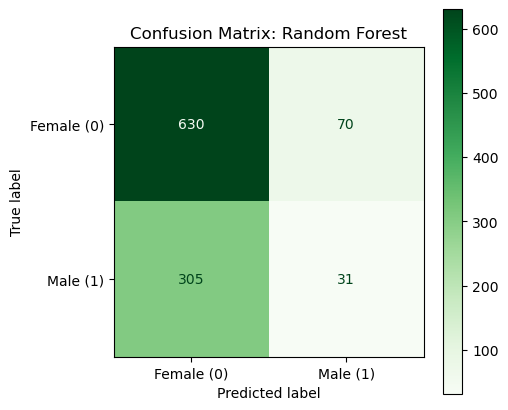

In [46]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

# Linear Regression (thresholded)
print("Linear Regression (thresholded at 0.5):")
print(classification_report(y_val, y_val_pred_binary, target_names=["Female (0)", "Male (1)"]))

cm_lr = confusion_matrix(y_val, y_val_pred_binary)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Female (0)", "Male (1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp_lr.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Linear Regression")
plt.show()

# Random Forest
print("Random Forest:")
print(classification_report(y_val, y_val_rf_pred_binary, target_names=["Female (0)", "Male (1)"]))

cm_rf = confusion_matrix(y_val, y_val_rf_pred_binary)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Female (0)", "Male (1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp_rf.plot(ax=ax, cmap='Greens', values_format='d')
plt.title("Confusion Matrix: Random Forest")
plt.show()

### Get sex targets

## ConvNeXt V2-Large

ConvNeXt V2-Large is a fully-convulutional neural network (CNN) (without attention layers) which borrows some principles from vision transformers (ViTs) <br> including parsing the input image into non-overlapping patches and learning their embeddings. <br> As a CNN, ConvNeXt V2-Large architecture has translation equivariance with local inductive bias, presuming a complex feature can be found anywhere in the image and that images are structured with nearby pixels related to each other. <br> These assumptions are useful in medical imaging: imagine the need to identify an exudate or edema anywhere in a fundus image. <br> Among the models tested for sex differentiation by mBRSET, ConvNeXt performed best with the highest F1 score (84.4%) in classifying sex from fundus images.

## Observe a sample

### Observe the range in observable vascular definition in portable fundus images

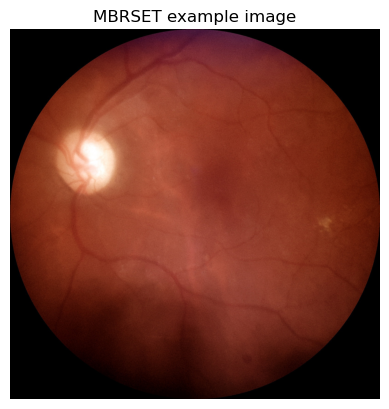

In [50]:
sample = '463.3.jpg'
img = Image.open(os.path.join(IMAGES_PATH, sample))
plt.imshow(img)
plt.title("MBRSET example image")
plt.axis('off')
plt.show()

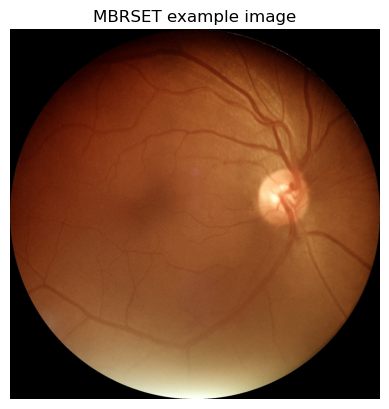

In [51]:
sample = '655.1.jpg'
# img = files[np.random.randint(0, len(files))]
img = Image.open(os.path.join(IMAGES_PATH, sample)) # Use a specific image for demonstration
plt.imshow(img) #Display the segmentation
plt.title("MBRSET example image")
plt.axis('off')
plt.show()